# An introduction to document embeddings

Natural Language Processing is a very useful field in the realm of Data Science. It can help you understand large corpora, and leverage decisions from it.

In this workshop we'll try to introduce you to the basics of NLP, in particular document embeddings. This notebook is meant to be an initial approach to the subject, and if everything works well, we expect you to be curious enough to continue with the challenges we propose at the end.

The question we'll be trying to answer in this workshop is _Can we use document embeddings to understand large corpora?_

We assume that for this workshop you have already set-up your environment to be able to work with this notebook, and know how to code in Python. If you have not set up properly the environment, or do not know what is a Jupyter Notebook, we suggest you take a look [here](https://github.com/bbc/datalab-ml-training).

_____

Let's first load some libraries that we will use throughtout this notebook. There is no need to know all of them at this stage. We'll go into more details when we'll need them.

In [1]:
import gensim
import nltk
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import seaborn as sns
import sys

from gensim.models.doc2vec import TaggedDocument
from utils.load import TextFiles
from matplotlib.colors import ListedColormap
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from numpy.random import randint

nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/tavard01/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tavard01/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## BBC Dataset

In this workshop we will be using the [BBC Dataset](http://mlg.ucd.ie/datasets/bbc.html): a public set of 2,225 labeled articles originated from BBC News, from 2004 to 2005, that can be used for machine learning research. The articles are divided in five categories:
- Business
- Entertainment
- Politics
- Sport
- Tech

We'll start our analysis from the [raw files from the BBC Dataset](http://mlg.ucd.ie/files/datasets/bbc-fulltext.zip). You can find the files in the `bbc_news` folder.

### What does an article look like?
Let's start by looking at one article, to try and understand how the files look like. Here the first business article.

In [2]:
with open('bbc_news/business/001.txt', 'r') as fp:
    raw_data = fp.read()

raw_data

'Ad sales boost Time Warner profit\n\nQuarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.\n\nThe firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.\n\nTime Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL\'s underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sig

As you can see, the file is well structured. We have a headline (or title) in the first line, followed by the article text below, where each paragraph is separated by two new line delimiters (`\n`).

In your DS career, you'll probably deal with text data way less cleaner than this dataset. In this case, you'll have to pre-process the original file, in order to get to a similar state.

### Let's now load all the files
For our example, the articles fit inside our memory, and we can create a function to load them all: `read_files_from_folder` navigates inside the folder tree, and returns a list of all raw texts.

In [3]:
def read_files_from_folder(root_folder):
    contents = []
    for root, folder, file_names in os.walk(root_folder):
        for file_name in file_names:
            if file_name.endswith('.txt'):
                file_path = os.path.join(root, file_name)
                with open(file_path, 'r') as fp:
                    contents.append(fp.read())
    return contents

raw_contents = read_files_from_folder('bbc_news')

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa3 in position 257: invalid start byte

**ERROR!**

What happened there? There are some files that were not encoded using 'UTF-8', so whenever we try to load them, we face a 'UnicodeDecodeError'. The best thing to do is to fix those files at creation, but sometimes that's not an option.

There's a trick, that works most of the time: using chardet to detect the file encoding. _BUT use with caution._

To make this workshop a bit faster, we've built a small class named `TextFiles` to deal with this issue and load the text files in memory. We'll use a function that also returns along with the raw text, the category of the article: output corpus being a list of dictionaries with the article (key `raw_content`) and the category (key `category_1`).

To tailor to our needs, we've also added the possibility to blacklist some files when creating our corpus (parameter `ignored_files` that takes a list of file names).

Have a look it the /lib folder if you want to see how it is built. And if you like this idea, we invite you to read how [Spark](https://spark.apache.org/docs/latest/) handles this, with the function [textFile](https://spark.apache.org/docs/latest/api/python/pyspark.html?highlight=textfile#pyspark.SparkContext.textFile).

In [4]:
raw_data = TextFiles().read_folder_with_categories('bbc_news')

In [5]:
raw_data[randint(0, len(raw_data))]

{'raw_content': 'Dollar drops on reserves concerns\n\nThe US dollar has dropped against major currencies on concerns that central banks may cut the amount of dollars they hold in their foreign reserves.\n\nComments by South Korea\'s central bank at the end of last week have sparked the recent round of dollar declines. South Korea, which has about $200bn in foreign reserves, said it plans instead to boost holdings of currencies such as the Australian and Canadian dollar. Analysts reckon that other nations may follow suit and now ditch the dollar. At 1300 GMT, the euro was up 0.9% on the day at 1.3187 euros per US dollar. The British pound had added 0.5% to break through the $1.90 level, while the dollar had fallen by 1.3% against the Japanese yen to trade at 104.16 yen.\n\nAt the start of the year, the US currency, which had lost 7% against the euro in the final three months of 2004 and had fallen to record lows, staged something of a recovery.\n\nAnalysts, however, pointed to the dolla

### Dataset exploration
Now that we have loaded all our articles, let's get some basic statistics. It's important to get a good overview of the data we are dealing with as it will drive us in the right direction for the processing, for the algorithms to consider etc. For example, we might need different models when dealing with tweets versus large documents.

Let's try to answer some of the following questions:
- Is our Dataset balanced? How many documents do we have per category?
- Are some files empty?
- Are there any duplicates?
- How many words are usually used? And paragraphs? And lines?
- What about the headline? How long are they?

#### Number of documents per category
How many articles do we have per category? If the distribution is unbalanced, and we are working on a classification problem, it might be needed to undersample some of them.

In [6]:
categories = ['business', 'entertainment', 'politics', 'sport', 'tech']
folder = 'bbc_news'

Text(0.5, 1.0, 'Number of documents per category on BBC News dataset\nPeriod: 2004-2005')

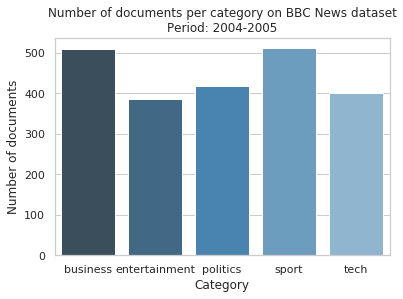

In [7]:
n_doc_per_category = pd.DataFrame({'category': categories})
n_doc_per_category['n_doc'] = n_doc_per_category.category.apply(
    lambda category: len(os.listdir(os.path.join(folder, category)))
)

sns.set(style='whitegrid')
sns.barplot(n_doc_per_category.category, n_doc_per_category.n_doc, palette='Blues_d')
plt.ylabel('Number of documents', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.title('Number of documents per category on BBC News dataset\nPeriod: 2004-2005')

The categories seem to be balanced. Yay!

#### Empty files and small articles
Let's check if we have any empty files in our dataset, or files that are very small. If we have any, we should remove them and that something we should handle when loading the files, i.e. in the `TextFiles` class.

In [8]:
def get_small_articles(raw_data, min_number_of_words=10):
    return [elnt for elnt in raw_data if len(elnt['raw_content']) < min_number_of_words]

small_articles = get_small_articles(raw_data)

if len(small_articles) > 0:
    print(f"We have unusual small articles ({len(small_articles)} in total).")
else:
    print("No small articles for the current dataset.")

No small articles for the current dataset.


That's good to know, at least there are no empty files in this dataset.

#### Duplicates
We need to get rid of the duplicates as they are not giving us extra information. The definition of similarity or duplication can be discussed, here we consider only exact duplicates.

In [9]:
uniques = set([elnt['raw_content'] for elnt in raw_data])
if len(uniques) is not len(raw_data):
    print(f"We have {len(raw_data) - len(uniques)} duplicates in our dataset.")
else:
    print("All documents are unique.")

We have 98 duplicates in our dataset.


Let's check now how many duplicates we have per category, as it can impact the balance of the corpus.

In [10]:
# Returns the unique and duplicates counts for each category
def get_counts(raw_data_df, category):
    category_df = raw_data_df[raw_data_df['category_1']==category]
    count_total = len(category_df)
    count_unique = len(category_df.raw_content.unique())
    count_duplicates = count_total - count_unique
    return {'category': category, 'uniques': count_unique, 'duplicates': count_duplicates}

raw_data_df = pd.DataFrame.from_records(raw_data)
duplicates_by_category = [get_counts(raw_data_df, category) for category in categories]

duplicates_by_category_df = pd.DataFrame(duplicates_by_category)

Text(0.5, 1.0, 'Number of documents per category break down by duplicates\n on BBC News dataset\nPeriod: 2004-2005')

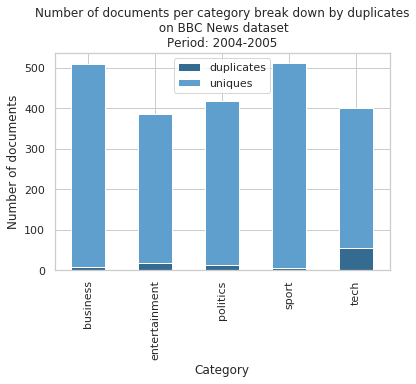

In [11]:
sns.set(style='whitegrid')
duplicates_by_category_df.set_index('category').plot(kind='bar', stacked=True,
                                                     colormap=ListedColormap(sns.color_palette("Blues_d", 2)))
plt.ylabel('Number of documents', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.title('Number of documents per category break down by duplicates\n on BBC News dataset\nPeriod: 2004-2005')

It seems the majority of the duplicates are in tech. If we train a classification model based on this dataset, we might need to balance our corpus.

Let's keep that in mind for the rest of our work.

### Data processing
When dealing with text data, we usually apply few transformations. First, we don't work with the raw text but with tokens. Also we usually remove stopwords, and we consider only the root of the works: which can be done by stemming, or lemmatization.

Finally, some work could be done to replace things like numbers, names, locations, organisations with known tokens. If we have a robust embedding model, it shouldn't matter if the person we're talking about is Theresa May, or Madonna: the context should tell us what the document is about.

We'll keep this for later iterations.

#### Stemming or Lemmatization?
Stemming and Lemmatization both generate the root form of the inflected words. The difference is that stem might not be an actual word whereas, lemma is an actual language word. This is easier for interpretation.

Stemming follows an algorithm with steps to perform on the words which makes it faster. Whereas, in lemmatization, a WordNet corpus is used, which makes it slower than the stemming process. To obtain the correct lemma, you also have to define the concept in which you want to lemmatize, or so called "parts-of-speech".

For a good introduction for both concepts, see [here](https://www.datacamp.com/community/tutorials/stemming-lemmatization-python).

Let's now try out these concepts with a concrete example.

In [12]:
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
porter_stemmer = PorterStemmer()
lancaster_stemmer = LancasterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()

In [13]:
ex_raw_text = "TimeWarner is to restate its accounts as part of efforts to resolve \
an inquiry into AOL by US market regulators. It has already offered to pay $300m to \
settle charges, in a deal that is under review by the SEC. The company said it was \
unable to estimate the amount it needed to set aside for legal reserves, which it \
previously set at $500m. It intends to adjust the way it accounts for a deal with \
German music publisher Bertelsmann's purchase of a stake in AOL Europe, which it had \
reported as advertising revenue. It will now book the sale of its stake in AOL Europe \
as a loss on the value of that stake."

In [14]:
tokens = tokenizer.tokenize(ex_raw_text.lower())
tokens[:10]

['timewarner',
 'is',
 'to',
 'restate',
 'its',
 'accounts',
 'as',
 'part',
 'of',
 'efforts']

In [15]:
tokens_no_stop_words = filter(lambda t: t not in stop_words, tokens)
list(tokens_no_stop_words)[:10]

['timewarner',
 'restate',
 'accounts',
 'part',
 'efforts',
 'resolve',
 'inquiry',
 'aol',
 'us',
 'market']

In [16]:
word_list = filter(lambda t: t not in stop_words, tokens[:20])
print("{0:20}{1:20}{2:20}{3:20}{4:20}".format("Word", "Porter Stemmer",
                                              "Lancaster Stemmer", "Lemmatizer",
                                              "Lemm pos=v"))
for word in word_list:
    print("{0:20}{1:20}{2:20}{3:20}{4:20}".format(
        word,
        porter_stemmer.stem(word),
        lancaster_stemmer.stem(word),
        wordnet_lemmatizer.lemmatize(word),
        wordnet_lemmatizer.lemmatize(word, pos="v") 
    ))

Word                Porter Stemmer      Lancaster Stemmer   Lemmatizer          Lemm pos=v          
timewarner          timewarn            timewarn            timewarner          timewarner          
restate             restat              rest                restate             restate             
accounts            account             account             account             account             
part                part                part                part                part                
efforts             effort              effort              effort              efforts             
resolve             resolv              resolv              resolve             resolve             
inquiry             inquiri             inquiry             inquiry             inquiry             
aol                 aol                 aol                 aol                 aol                 
us                  us                  us                  u                   us         

Now let's apply these transformation to our corpus. We'll start by using the Porter Stemmer to get the root of each word. In order to apply easily different transformations, we recommend to use Pipelines (an example of how to build a transformation is under `utils/preprocessing.py`, and you can plug that into a [Pipeline object](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)).

In [17]:
def process_text(raw_content):
    raw_content_lowercase = raw_content.lower()
    tokens = tokenizer.tokenize(raw_content_lowercase)
    tokens_no_stop_words = filter(lambda t: t not in stop_words, tokens)
    token_stem = map(lambda t: porter_stemmer.stem(t), tokens_no_stop_words)
    token_non_empty = filter(lambda t: len(t) > 1, token_stem)
    return token_non_empty

In [18]:
for article in raw_data:
    article['tokens'] = process_text(article['raw_content'])

In [19]:
print(raw_data[0])

{'raw_content': 'Ad sales boost Time Warner profit\n\nQuarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.\n\nThe firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.\n\nTime Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL\'s underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and

### Why embeddings?
Whenever we're building a model to capture how similar two documents are, we need to consider how we are representing the document.

For example, depending on the technique we use for processing the text, the three phrases below would have the same coded values (or tokens).

(1) This is completely meaning**ful** to me.

(2) This is completely meaning**less** to me.

(3) To be complete: this is meaningful to me. 

After removing stopwords, tokenizing and stemming, we might end in the same vector representation, because some techniques depend on the tokens alone and do not take into consideration the context.

This is something that we definitely do no want, what lead us to use techniques like [Non-Negative Matrix Factorization](https://arxiv.org/abs/1401.5226), Latent Dirichlet Allocation (LDA), and Document Embeddings (like [Doc2Vec](https://arxiv.org/pdf/1405.4053v2.pdf), [BERT](https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html) and [ELMo](https://allennlp.org/elmo)). In some cases, simpler models can be sufficient, but usually only when we have _lots of data_.

With embeddings, in particular, we are able to sum and subtract the word vectors. A well known example is:
_QUEEN_ - _WOMAN_ + _MAN_ = _KING_.

This is closer to what we would expect from a language model!

For the embeddings we consider the [Doc2Vec algorithm](https://radimrehurek.com/gensim/models/doc2vec.html) from the Gensim library, similar to [here](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/doc2vec-lee.ipynb). This is based on two papers that used either [hierarchical softmax](https://arxiv.org/pdf/1301.3781.pdf) or [negative sampling](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf).

In order to use it, we first need to convert our tokens into [TaggedDocument](https://radimrehurek.com/gensim/models/doc2vec.html#gensim.models.doc2vec.TaggedDocument) objects. Tagged documents are documents with an associated label. You could simply use one number for each document and run the model, but when more than one document contains the same label, the model will try to infer the information from documents with the shared tag.

In [20]:
tagged_documents = [
    TaggedDocument(list(elnt['tokens']), [f'article_{idx}']) for idx, elnt in enumerate(raw_data)
]

In [21]:
tagged_documents[randint(0, len(tagged_documents))]

TaggedDocument(words=['net', 'fingerprint', 'combat', 'attack', 'eighti', 'larg', 'net', 'servic', 'firm', 'switch', 'softwar', 'spot', 'stop', 'net', 'attack', 'automat', 'system', 'creat', 'digit', 'fingerprint', 'ongo', 'incid', 'sent', 'everi', 'network', 'affect', 'firm', 'involv', 'smart', 'sens', 'system', 'believ', 'help', 'trace', 'attack', 'back', 'sourc', 'data', 'gather', 'pass', 'polic', 'help', 'build', 'intellig', 'behind', 'worm', 'outbreak', 'denial', 'servic', 'attack', 'firm', 'sign', 'sens', 'system', 'includ', 'mci', 'bt', 'deutsch', 'telekom', 'energi', 'ntt', 'bell', 'canada', 'mani', 'other', 'creation', 'fingerprint', 'system', 'broker', 'us', 'firm', 'arbor', 'network', 'signatur', 'attack', 'pass', 'anyon', 'suffer', 'weight', 'attack', 'increasingli', 'comput', 'crimin', 'use', 'swarm', 'remot', 'control', 'comput', 'carri', 'denial', 'servic', 'attack', 'websit', 'launch', 'worm', 'relay', 'spam', 'around', 'net', 'seen', 'attack', 'involv', 'five', 'ten', 

Try to play with the hyperparameters here, to get a better result.

In [22]:
# You need to set the proper hyperparameter models here
doc2vec_model = gensim.models.Doc2Vec(tagged_documents, dm=1, vector_size=5, window=5,
                                      alpha=0.025, min_alpha=0.025, min_count=0)

In [23]:
# This won't be good the first time you run. You need to change the hyperparameters
print(doc2vec_model.wv.most_similar('court'))

[('bafin', 0.9949619770050049), ('ambigu', 0.9948400855064392), ('521', 0.9946093559265137), ('draft', 0.9932632446289062), ('jameson', 0.9924834370613098), ('bankrol', 0.9916859865188599), ('diemont', 0.990506649017334), ('pelvi', 0.9902675747871399), ('wollaton', 0.9898276925086975), ('activist', 0.9892165660858154)]


In [24]:
for idx, article in enumerate(raw_data):
    article['embeddings'] = doc2vec_model.docvecs[f'article_{idx}']

In [25]:
# Checking if the embeddings were added to the document
print(raw_data[randint(0, len(raw_data))])

{'raw_content': 'Call for Kenteris to be cleared\n\nKostas Kenteris\' lawyer has called for the doping charges against the Greek sprinter to be dropped.\n\nGregory Ioannidis has submitted new evidence to a Greek athletics tribunal which he claims proves the former Olympic champion has no case to answer. Kenteris and compatriot Katerina Thanou were given provisional suspensions in December for failing to take drugs tests before the Athens Olympics. The Greek tribunal is expected to give its verdict early next week. Kenteris and Thanou withdrew from the Athens Olympics last August after missing drugs tests on the eve of the opening ceremony. They were also alleged to have avoided tests in Tel Aviv and Chicago before the Games.\n\nBut Ioannidis said: "Everything overwhelmingly shows that the charges should be dropped." Ioannidis also said he has presented evidence that will throw a different light on the events leading up to the pair\'s sensational withdrawal from the Athens Games. The la

## Next Steps

So we've reached the end of our workshop, but this is just the beginning. From this point onwards, we leave to you some open questions, that may guide on your journey.

- Did you notice that the model is saving some specific names? How would the model perform if you replace named entities with placeholders?
- How would you check the model above for different types of bias? How would you check, for example, if the model has a gender or race bias?
- What would be the benefits of plugging the process from above into a Pipeline object?
- What would be the differences in implementation between the Pipeline you can create here for what you have in Apache Beam or Spark?
- How would you refactor this without using Gensim, and using Keras or Tensorflow instead?
- What would need to change in your code if you'd like to train this model with data that doesn't fit in memory of a single machine?
- How can you detect the minumum number of articles needed to train your model for your use case?
- Would you use cross validation when training this model? Why and how?
- Is there a way to use Bayesian Optimization, or a simple grid search to find the best hyperparameters?
- How would you compare Doc2Vec with LDA, NNMF, BERT or ELMo?
- If your problem was to just classify the text into multiple categories, what would you do differently?
- How can you make this model available as a service?